## Solving the Frog Croaking Puzzle

Consider an array of $n+1$ lilypads on a pond, numbered $0$ to $n$. A frog sits on a lilypad other than the lilypads numbered $0$ or $n$.  When on lilypad $i$ ($1\leq i \leq n-1$), the frog can croak one of two sounds $A$ or $B$. If it croaks $A$ when on lilypad $i$ ($1 \leq i \leq n-1$), it is thrown to lilypad $i-1$ with probability $\frac i n$ and is thrown to lilypad $i+1$ with probability $\frac {n-i} n$. If it croaks $B$ when on lilypad $i$ ($1\leq i \leq n-1$), it is thrown to one of the lilypads $0, \ldots, i-1, i+1, \ldots n$ with uniform probability $\frac 1 n$. A snake, perched on lilypad $0$, will eat the frog if the frog lands on lilypad $0$. The frog can escape the pond (and hence, escape the snake!) if it lands on lilypad $n$.

What should the frog croak when on each of the lilypads $1, 2, \ldots, n-1$, in order to maximize the probability of escaping the pond (i.e., reaching lilypad $n$ before reaching lilypad $0$)? Although there are more than one ways of solving this problem, we'd like to solve it by modeling it as an MDP and identifying the Optimal Policy.

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.abspath("."), os.pardir)))

import itertools
from dataclasses import dataclass
from enum import StrEnum, IntEnum

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.distributions import FiniteDistribution, Categorical, Constant
from rl.policy import FinitePolicy
from rl.dynamic_programming.policy_methods import policy_iteration_result

In [2]:
@dataclass(frozen=True)
class LilyPad:
    position: int = 1

    def generate_reward(self, num_pads) -> float:
        if self.position == num_pads:
            return 1.0
        else:
            return 0.0


class Sound(StrEnum):
    A = "A"
    B = "B"


class FrogEscapePuzzle(FiniteMarkovDecisionProcess[LilyPad, Sound]):
    num_pads: int

    def __init__(self, num_pads: int) -> None:
        self.num_pads = num_pads

        super().__init__(mapping=self.generate_mapping())

    def generate_mapping(
        self,
    ) -> dict[LilyPad, dict[Sound, FiniteDistribution[tuple[LilyPad, float]]]]:
        mapping = dict()

        for current_position in range(1, self.num_pads):
            current_state = LilyPad(position=current_position)
            action_dist = dict()
            # left_prob = current_position / self.num_pads

            # when the frog croaks sound A
            left_position = LilyPad(position=current_position - 1)
            right_position = LilyPad(position=current_position + 1)

            action_dist[Sound.A] = Categorical(
                {
                    (
                        left_position,
                        left_position.generate_reward(self.num_pads),
                    ): current_position,
                    (
                        right_position,
                        right_position.generate_reward(self.num_pads),
                    ): self.num_pads - current_position,
                }
            )

            # when the frog croaks sound B
            sub_dist = dict()

            for next_position in range(self.num_pads + 1):
                next_state = LilyPad(position=next_position)
                reward = next_state.generate_reward(self.num_pads)
                sub_dist[(next_state, reward)] = 1.0

            action_dist[Sound.B] = Categorical(sub_dist)

            mapping[current_state] = action_dist

        return mapping

In [3]:
N = 5

mdp = FrogEscapePuzzle(num_pads=N)

mdp

From State LilyPad(position=1):
  With Action A:
    To [Terminal State LilyPad(position=0) and Reward 0.000] with Probability 0.200
    To [State LilyPad(position=2) and Reward 0.000] with Probability 0.800
  With Action B:
    To [Terminal State LilyPad(position=0) and Reward 0.000] with Probability 0.167
    To [State LilyPad(position=1) and Reward 0.000] with Probability 0.167
    To [State LilyPad(position=2) and Reward 0.000] with Probability 0.167
    To [State LilyPad(position=3) and Reward 0.000] with Probability 0.167
    To [State LilyPad(position=4) and Reward 0.000] with Probability 0.167
    To [Terminal State LilyPad(position=5) and Reward 1.000] with Probability 0.167
From State LilyPad(position=2):
  With Action A:
    To [State LilyPad(position=1) and Reward 0.000] with Probability 0.400
    To [State LilyPad(position=3) and Reward 0.000] with Probability 0.600
  With Action B:
    To [Terminal State LilyPad(position=0) and Reward 0.000] with Probability 0.167
    To 

### What happens if we use a uniform policy?

In [4]:
policy = FinitePolicy(
    policy_map={
        LilyPad(position=position): Categorical({Sound.A: 1.0, Sound.B: 1.0})
        for position in range(1, N)
    }
)

policy

For State LilyPad(position=1):
  Do Action A with Probability 0.500
  Do Action B with Probability 0.500
For State LilyPad(position=2):
  Do Action A with Probability 0.500
  Do Action B with Probability 0.500
For State LilyPad(position=3):
  Do Action A with Probability 0.500
  Do Action B with Probability 0.500
For State LilyPad(position=4):
  Do Action A with Probability 0.500
  Do Action B with Probability 0.500

In [5]:
implied_mrp = mdp.apply_finite_policy(policy=policy)

implied_mrp.compute_value_function_vector(gamma=1, pprint=True)

{LilyPad(position=1): 0.44672131147540994,
 LilyPad(position=2): 0.49180327868852464,
 LilyPad(position=3): 0.5081967213114755,
 LilyPad(position=4): 0.5532786885245903}

The values above represent the probabilities of escaping the pond from that lily pad.

### What is the optimal policy?
The optimal policy is one that results in the highest probability of escaping the pond. So we generate all possible policies, evaluate the implied MRP's value function for each of those policies, and keep the policy that generates the highest probability of escaping the pond.

In [6]:
optimal_vf = np.zeros(N - 1)
optimal_policy: FinitePolicy = None

for actions in itertools.product([Sound.A, Sound.B], repeat=N - 1):
    policy = FinitePolicy(
        policy_map={
            LilyPad(position=position + 1): Constant(value=action)
            for position, action in enumerate(actions)
        }
    )

    implied_mrp = mdp.apply_finite_policy(policy=policy)
    vf = implied_mrp.compute_value_function_vector(gamma=1.0)

    if np.any(vf > optimal_vf):
        optimal_vf = vf
        optimal_policy = policy

In [7]:
optimal_vf

array([0.64285714, 0.69642857, 0.73214286, 0.78571429])

In [8]:
optimal_policy

For State LilyPad(position=1):
  Do Action B with Probability 1.000
For State LilyPad(position=2):
  Do Action A with Probability 1.000
For State LilyPad(position=3):
  Do Action A with Probability 1.000
For State LilyPad(position=4):
  Do Action A with Probability 1.000

### Does Policy Iteration produce the same result?

In [9]:
optimal_vf, optimal_policy = policy_iteration_result(mdp=mdp, gamma=1.0)

In [10]:
{s.state: v.item() for s, v in optimal_vf.items()}

{LilyPad(position=1): 0.6427939882372476,
 LilyPad(position=2): 0.6963347864771492,
 LilyPad(position=3): 0.7320424701512209,
 LilyPad(position=4): 0.7856261883264612}

In [11]:
optimal_policy

For State LilyPad(position=1): Do Action B
For State LilyPad(position=2): Do Action A
For State LilyPad(position=3): Do Action A
For State LilyPad(position=4): Do Action A

### How does the Optimal Escape-Probability/Croak change a a function of the states?

In [12]:
outcomes: pd.DataFrame = None

for size in range(3, 16):
    mdp = FrogEscapePuzzle(num_pads=size)
    optimal_vf, optimal_policy = policy_iteration_result(mdp=mdp, gamma=1.0)

    tmp = pd.DataFrame(
        [(size, s.state.position, reward) for s, reward in optimal_vf.items()],
        columns=["Size", "Lily Pad", "Probability"],
    )

    tmp["Policy"] = [a for a in optimal_policy.action_for.values()]

    if outcomes is None:
        outcomes = tmp
    else:
        outcomes = pd.concat((outcomes, tmp))

In [13]:
probabilities = pd.pivot_table(
    data=outcomes,
    index="Lily Pad",
    columns="Size",
    values="Probability",
    dropna=False,
).sort_index(ascending=False)

In [14]:
policies = pd.pivot(
    data=outcomes,
    index="Lily Pad",
    columns="Size",
    values="Policy",
).sort_index(ascending=False)

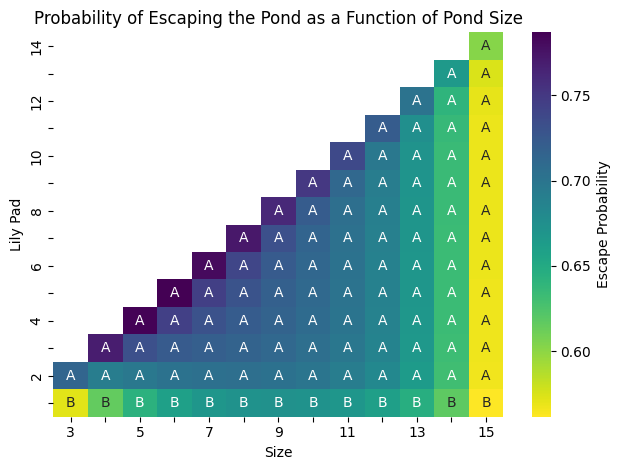

In [19]:
ax = sns.heatmap(
    data=probabilities,
    annot=policies,
    fmt="",
    cmap="viridis_r",
    cbar_kws={"label": "Escape Probability"},
)

plt.title("Probability of Escaping the Pond as a Function of Pond Size")

for i, label in enumerate(ax.get_xticklabels()):
    if i % 2 != 0:
        label.set_visible(False)


for i, label in enumerate(ax.get_yticklabels()):
    if i % 2 != 0:
        label.set_visible(False)


plt.tight_layout()
plt.show()